You may have to install the pyblock package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.default'] = 'regular'
#%matplotlib widget
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF, InterRDF_s
import MDAnalysis.transformations
from scipy.io import mmwrite
from scipy.interpolate import CubicSpline
import scipy.stats as st
from scipy.stats import linregress

import pyblock

/u/home/w/wborrell/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the universe information

In [121]:
u47 = mda.Universe('/u/home/w/wborrell/xyz_47_298K.xyz', dt=0.05)

In [122]:
dim47 = [11.212, 11.212, 11.212, 90, 90, 90]
transform47 = mda.transformations.boxdimensions.set_dimensions(dim47)
u47.trajectory.add_transformations(transform47)

In [123]:
bonds = []
for o in range(0, len(u47.atoms)-3, 3):
    bonds.extend([(o, o+1), (o, o+2)])

u47.add_TopologyAttr('bonds', bonds)
u47.bonds

<TopologyGroup containing 94 bonds>

In [124]:
# define half the box length for g(r) stuff

In [125]:
br47 = dim47[0]/2

In [5]:
# here's all the functions we need

In [253]:
def rdf_bin(u, bc, maxi, p1, p2):
    rdf = InterRDF(u.select_atoms(p1), u.select_atoms(p2), range=[0.0,maxi], nbins=bc)
    rdf.run()
    plt.plot(rdf.results.bins, rdf.results.rdf)
    plt.show()

In [7]:
def weight(r, br):
    return 4*np.pi*r**2*(1-((3*(r/br))/(2))+(((r/br)**3)/(2)))

In [8]:
## This is the function for calculating the molar volume
## The 45*10**-6 number is the isothermal compressibility
## of PBE0 water - so we really should try to find values
## for this for our functionals if possible

In [9]:
def vm_pbe0K2_rg(gofr_y, gofr_x, br, end_int, start_int=0):
    weights = [weight(i, br) for i in gofr_x]
    intf = CubicSpline(x=gofr_x, y=(weights*(gofr_y-1)), bc_type='natural')
    inte = (1*10**(-30))*intf.integrate(a=start_int, b=end_int)
    t1 = (1.380649*10**(-23))*298*(45*10**(-6))*(1.01325*10**(-6))*(1/101325)
    return (t1 - inte)*(6.022*10**(23))*1000000

In [10]:
def all_rdfs(uni, br, end, nbins, fname='name Cl', sname='name X'):
    rdfs = []
    for i in range(len(range(0,len(uni.trajectory)))-1):
        rdfs.append(InterRDF(uni.select_atoms(fname), uni.select_atoms(sname), range=[0.0,br], nbins=nbins).run(start=range(0,len(uni.trajectory))[i], stop=range(0,len(uni.trajectory))[i+1]))
    return rdfs

In [11]:
def block_avg_err(data):
    reblk_dat = pyblock.blocking.reblock(data)
    op = pyblock.blocking.find_optimal_block(len(data), reblk_dat)
    if np.isnan(op[0]):
        return reblk_dat[np.argmax(np.array([reblk_dat[i][4] for i in range(len(reblk_dat))]))]
    else:
        return reblk_dat[op[0]]

In [12]:
blk_mean_err = lambda dat : np.array([block_avg_err(np.array(dat).T[-1])[2], 2*block_avg_err(np.array(dat).T[-1])[4]])

In [13]:
map_blk_avg = lambda x : block_avg_err(x)[2]

In [14]:
map_blk_err = lambda x : block_avg_err(x)[4]

Kirkwood-Buff theory say that we can calculate the partial molar volume:
$$V_M=k_BT\kappa_T-G_{\alpha \beta}$$

where:
$$G_{\alpha \beta}=\int_0^\infty[g_{\alpha \beta}(r)-1]dr$$

But in reality, our simulation box isn't infinite in length, so we introduce a weighting function:
$$G_{\alpha \beta}=\int_0^R[g_{\alpha \beta}(r)-1]w(r;R)dr$$

The g(r) here is between the electron and the center of mass of the water.

The first thing we need to do is convert our xyz files from having the coordinates of each oxygen and hydrogen in water to just be the center of mass of the water.

In [16]:
mvec = np.array([15.999, 1.008, 1.008]) # the masses of oxygen, hydrogen, hydrogen
smvec = np.sum(mvec) # the sum of the masses

In [16]:
# for a single water:
# do the dot product of the x,y, or z position vector for each atom with the mass vector, then divide by total mass

In [229]:
np.array([np.sum(np.dot(u47.atoms.positions[0:-1][0:3][:,i], mvec))/smvec for i in range(3)])

array([6.53841947, 5.02184631, 5.35494262])

In [18]:
# notice that the com is very close to the oxygen of the water, which makes sense

In [21]:
def wat_com(wat):
    return np.array([np.sum(np.dot(wat[:,i], mvec))/smvec for i in range(3)])

In [22]:
# do it over the whole trajectory

In [217]:
all_coms = []
for ts in u47.trajectory:
    all_coms.append(np.array([wat_com(ts.positions[0:-1][i:(i+3)]) for i in np.arange(0,len(u47.atoms)-3,3)]))
all_coms = np.array(all_coms)

In [218]:
all_coms.shape # 151 timesteps, 47 waters, each com is a length 3 vector

(151, 47, 3)

In [190]:
np.unique(list(map(len,all_coms))) # make sure we have all 47 waters done

array([47])

In [ ]:
# so all_coms is a big list of lists of water centers of mass
# now we get the electron positions

In [225]:
znsel = u47.select_atoms('name Zn')
all_elecs = []
for ts in u47.trajectory:
    all_elecs.append(znsel.positions[0])
all_elecs = np.array(all_elecs)

In [226]:
all_elecs.shape

(151, 3)

Now we should print this into a new xyz file, which has water com's and the electron position:

In [49]:
# keep scientific notation from happening

np.set_printoptions(suppress=True)

In [211]:
# define the atomic symbols

symbols = ['X']*len(all_coms[0])

In [244]:
with open('com_py_47.xyz', 'a') as file:
    for ts in range(len(all_coms)):
        file.write(str(len(all_coms[0])+1)+'\n')
        file.write('comment\n')
        for wat in range(len(all_coms[ts])):
            file.write(" ".join(np.insert(all_coms[ts][wat].astype('str'), 0, symbols[wat]))+'\n')
        file.write(" ".join(np.insert(all_elecs[ts].astype('str'), 0, 'Zn'))+'\n')
file.close()

Once this is done you don't have to repeat this again, just follow below.

Now define a new universe for the centers of mass:

In [245]:
u47com = mda.Universe('/u/home/w/wborrell/com_py_47.xyz', dt=0.05)

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [246]:
dim47 = [11.212, 11.212, 11.212, 90, 90, 90]
transform47 = mda.transformations.boxdimensions.set_dimensions(dim47)
u47com.trajectory.add_transformations(transform47)

First thing is to make sure the RDF looks OK. It should look very similar to the electron-oxygen RDF:

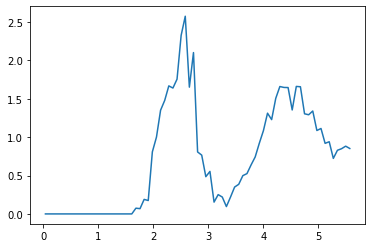

In [215]:
rdf_bin(u47, 20, br47, 'name Zn', 'name O')

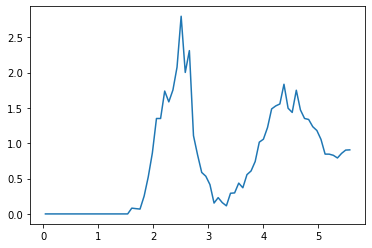

In [247]:
rdf_bin(u47com, 10, br47, 'name Zn', 'name X')

We need to find the best number of histogram bins for the g(r). You should take the smallest number of bins that gives a good looking result:

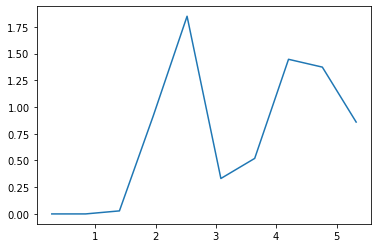

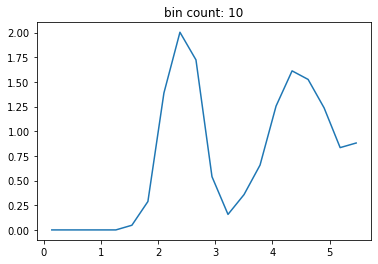

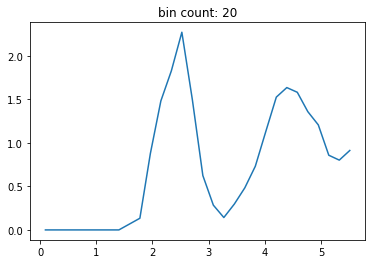

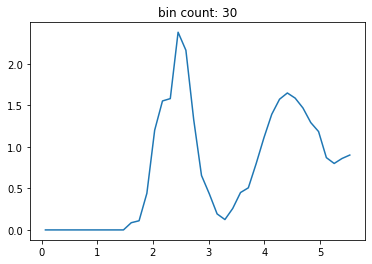

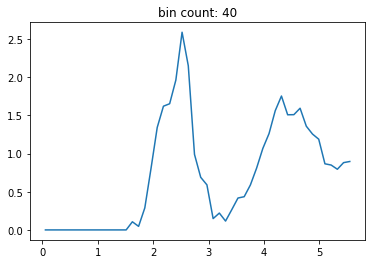

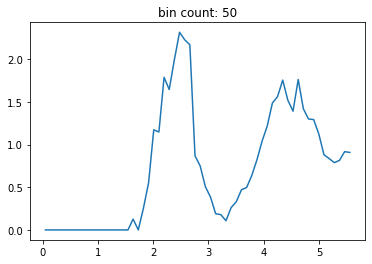

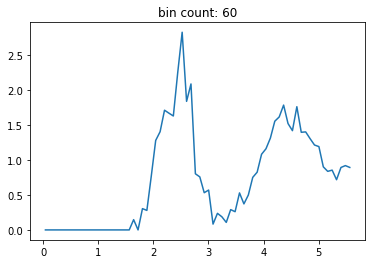

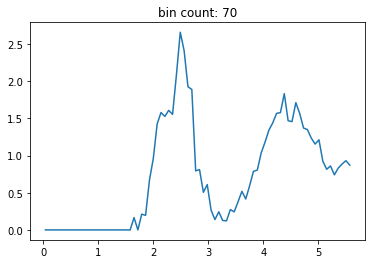

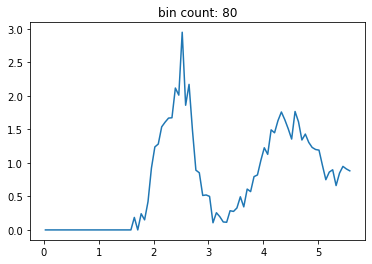

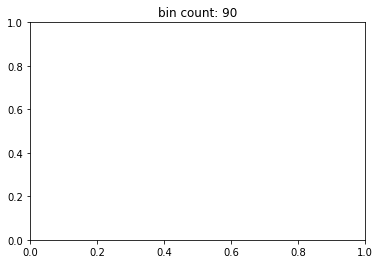

In [255]:
# 30 or 40 looks good

for i in np.arange(10,100,10):
    rdf_bin(u47com, i, br47, 'name Zn', 'name X')
    plt.title('bin count: '+str(i))

In [256]:
bc47 = 40

Plot the ensemble averaged RDF:

In [259]:
ardfs47 = all_rdfs(u47com, br47, br47, bc47, 'name Zn', 'name X')

/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:316: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/MDAnalysis/analysis/rdf.py:324: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/u/home/w/wborrell/.local/lib/python3.9/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in double_scalars
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:


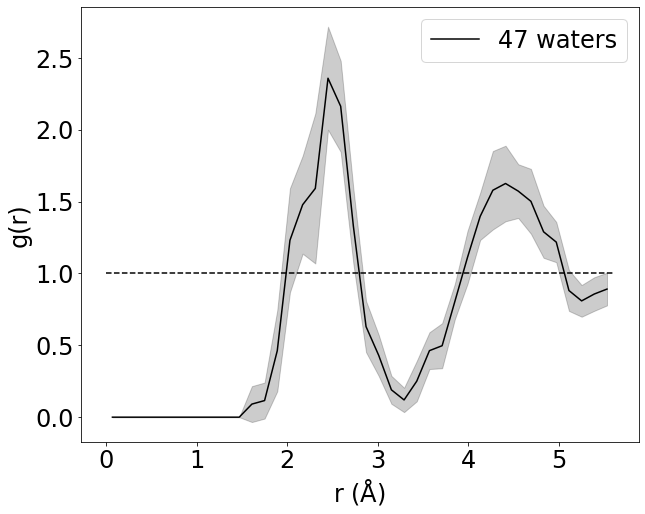

In [268]:
plt.figure(figsize=(10,8))

plt.plot(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
        label='47 waters', color='k')
plt.fill_between(ardfs47[0].bins, np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))-2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T))),
                 np.array(list(map(map_blk_avg, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))+2*np.array(list(map(map_blk_err, np.array([ardfs47[i].rdf for i in range(len(ardfs47))]).T)))
                 , alpha=0.2, color='k')
plt.hlines(1.0, 0,br47, colors='k', linestyles='--')

plt.xlabel('r ($\AA$)', fontsize=24)
plt.ylabel('g(r)', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

And now calculate the ensemble average molar volume:

In [269]:
vmb47 = block_avg_err(np.array([vm_pbe0K2_rg(ardfs47[i].rdf, ardfs47[i].bins, br47, br47) for i in range(len(ardfs47))]))

In [275]:
# the Vm is ~ 8 +- 0.314 cm^3/mol

np.array([vmb47[i] for i in [2,4]])

array([7.9373688, 0.3141926])

And if we want we can parse the contributions of each solvent shell:

In [284]:
ends_47 = [3.0, 4.07, 5.47]
inits_47 = [0.0, 3.0, 4.07]
all_conts_47 = []
for rdf in range(len(ardfs47)):
    tconts_47 = [vm_pbe0K2_rg(ardfs47[rdf].results.rdf, ardfs47[rdf].results.bins, br47, ends_47[i], inits_47[i]) for i in range(len(ends_47))]
    all_conts_47.append(tconts_47)

In [ ]:
# most of the contribution comes from the first shell:

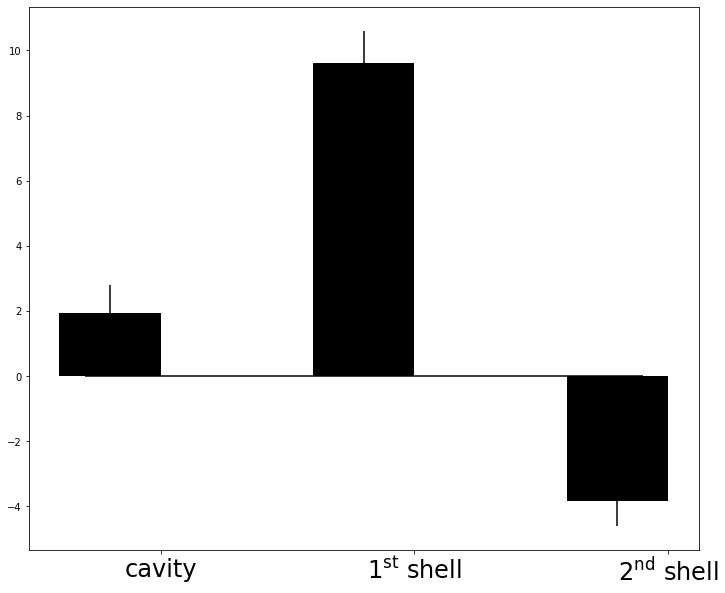

In [295]:
plt.figure(figsize=(12,10))

x = np.arange(len(np.array(all_conts_47).T))
y1 = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[2]) for i in range(len(np.array(all_conts_47).T))])
y1_err = np.array([np.array(block_avg_err(np.array(all_conts_47).T[i])[4]*2) for i in range(len(np.array(all_conts_47).T))])

width = 0.40
plt.xticks(x, ['cavity','1$^{st}$ shell','2$^{nd}$ shell'], fontsize=24)
plt.hlines(0, -.3, 1.9, color='k')

plt.bar(x-0.2, y1, width, label='47 waters', color='k', yerr=y1_err)

plt.show()